# EDA
- price 상한가 37억, 11억만 삭제
- 하한가만 조정
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import rankdata

In [2]:
df = pd.read_csv('vehicles_processed.csv')

- describe은 제외하도록 함

# Data Cleaning
- price, odometer 0인 항목은 삭제하도록 함
- odometer는 전체 데이터 셋에서의 quartile whisker 내부 항목만 분석 대상으로 함
- 가격대의 경우, 제조사별로 percentile 0~100% 내부의 항목만 분석대상으로 함
    - 100 달러 미만은 기본적으로 삭제함
    - 페라리, 애스턴 마틴과 같은 고급 브랜드의 경우, 전 데이터셋에 대한 쿼타일 분석 시, 해당 브랜드의 모든 모델의 가격대가 이상치로 나타나기 때문임

In [3]:
# 0인 수치 데이터 모두 제외
df = df[df['price'] > 0]
df = df[df['odometer'] > 0]

df.reset_index(drop=True, inplace=True)

In [4]:
# 카테고리 항목 정리 -> 현저히 낮은 수치로 나타나는 값들은 모두 기타로 묶음

df['paint_color'].replace(['red', 'blue', 'white', 'brown', 'grey',
       'yellow', 'green', 'custom', 'purple', 'orange'], 'other', inplace=True)
df['cylinders'].replace(['5 cylinders',
       '10 cylinders', '3 cylinders', 'other', '12 cylinders'], 'other', inplace=True)
df['transmission'].replace(['other', 'manual'], 'other', inplace=True)
df['fuel'].replace(['electric','hybrid','diesel'], 'other', inplace=True)

### odometer 정제

- whisker 내부 데이터만 택함

In [5]:
q_75 = df['odometer'].quantile(0.75)
q_25 = df['odometer'].quantile(0.25)
IQR = q_75 - q_25
upper_bound = q_25 + 1.5*IQR
lower_bound = q_75 - 1.5*IQR
print("Quantile 75: ", q_75)
print("Quantile 25: ", q_25)
print("IQR: ", IQR)
print("Upper bound: ", upper_bound) 
print("Lower bound: ", lower_bound)

cleaned_1 = df[(df['odometer'] <= upper_bound)&(df['odometer'] >= lower_bound)]
cleaned_1.reset_index(inplace= True, drop = True)
cleaned_1

Quantile 75:  148577.0
Quantile 25:  56344.0
IQR:  92233.0
Upper bound:  194693.5
Lower bound:  10227.5


,id,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,description
0,7316356412,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,automatic,rwd,truck,black,2013 F-150 XLT V6 4 Door. Good condition. Leve...
1,7316343444,27990,2012.0,gmc,sierra 2500 hd extended cab,good,8 cylinders,gas,68696.0,other,4wd,pickup,black,Carvana is the safer way to buy a car During t...
2,7316304717,34590,2016.0,chevrolet,silverado 1500 double,good,6 cylinders,gas,29499.0,other,4wd,pickup,silver,Carvana is the safer way to buy a car During t...
3,7316285779,35000,2019.0,toyota,tacoma,excellent,6 cylinders,gas,43000.0,automatic,4wd,truck,other,Selling my 2019 Toyota Tacoma TRD Off Road Dou...
4,7316257769,29990,2016.0,chevrolet,colorado extended cab,good,6 cylinders,gas,17302.0,other,4wd,pickup,other,Carvana is the safer way to buy a car During t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96454,7301954392,41990,2019.0,toyota,4runner limited sport,good,6 cylinders,gas,36630.0,other,4wd,SUV,other,Carvana is the safer way to buy a car During t...
96455,7301951544,39990,2017.0,infiniti,qx80 sport utility 4d,good,8 cylinders,gas,41664.0,automatic,4wd,other,black,Carvana is the safer way to buy a car During t...
96456,7301949190,32990,2016.0,infiniti,qx80 sport utility 4d,good,8 cylinders,gas,55612.0,automatic,rwd,other,black,Carvana is the safer way to buy a car During t...
96457,7301591199,33590,2018.0,lexus,gs 350 sedan 4d,good,6 cylinders,gas,30814.0,automatic,rwd,sedan,other,Carvana is the safer way to buy a car During t...


In [6]:
show_series(cleaned_1, 'odometer')

NameError: name 'show_series' is not defined

### price 정제
- 하한선은 quantile 25% 부터

In [ ]:
def clean_price(data):
    mans = data['manufacturer'].unique().tolist()
    data = data.groupby(['manufacturer','model','id']).sum()
    data.reset_index(inplace=True)
    new_df = []
    for man in mans:
        targ = data[data['manufacturer'] == man]
        targ.reset_index(inplace=True, drop = True)
        q_25 = targ['price'].quantile(0.25)
        q_75 = targ['price'].quantile(0.75)
        IQR = q_75 - q_25
        upper_bound = q_25+1.5*IQR
        lower_bound = q_25
        
        print("=== [%s] ==="%man)
        print("Number of : ", len(targ))
        print("Quantile 75: ", q_75)
        print("Quantile 25: ", q_25)
        print("IQR: ", IQR)
        print("Upper bound: ", upper_bound) 
        print("Lower bound: ", lower_bound)
        print("Max: ", targ['price'].max())
        print("Min: ", targ['price'].min())
        print("Mean: ", targ['price'].mean())
        print("Median: ", targ['price'].median())
        
        targ = targ[(targ['price'] <= upper_bound)&(targ['price'] >= lower_bound)]
        targ.reset_index(inplace= True, drop = True)
        new_df.append(targ)
        
    new_df = pd.concat(new_df)
    new_df.reset_index(inplace= True, drop = True) 
    return new_df

cleaned_2 = clean_price(cleaned_1)
cleaned_2

=== [ford] ===
Number of :  16664
Quantile 75:  26990.0
Quantile 25:  7495.0
IQR:  19495.0
Upper bound:  36737.5
Lower bound:  7495.0
Max:  1111111111
Min:  1
Mean:  84814.81661065771
Median:  13995.0
=== [gmc] ===
Number of :  3957
Quantile 75:  34990.0
Quantile 25:  12500.0
IQR:  22490.0
Upper bound:  46235.0
Lower bound:  12500.0
Max:  90000
Min:  1
Mean:  24493.261056355826
Median:  24990.0
=== [chevrolet] ===
Number of :  14382
Quantile 75:  28900.0
Quantile 25:  7500.0
IQR:  21400.0
Upper bound:  39600.0
Lower bound:  7500.0
Max:  125000
Min:  1
Mean:  18681.039702405786
Median:  15000.0
=== [toyota] ===
Number of :  7716
Quantile 75:  22000.0
Quantile 25:  6700.0
IQR:  15300.0
Upper bound:  29650.0
Lower bound:  6700.0
Max:  3736928711
Min:  1
Mean:  499824.0964230171
Median:  11500.0
=== [jeep] ===
Number of :  4947
Quantile 75:  28682.5
Quantile 25:  8261.0
IQR:  20421.5
Upper bound:  38893.25
Lower bound:  8261.0
Max:  1234567
Min:  1
Mean:  19258.92803719426
Median:  17450.0

,manufacturer,model,id,price,year,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color
0,ford,-150 xlt,7312098448,20997,2014.0,like new,8 cylinders,gas,145000.0,automatic,4wd,truck,silver
1,ford,/vmi conversion van,7316387772,18500,2013.0,excellent,8 cylinders,gas,47362.0,automatic,rwd,van,other
2,ford,150,7302231495,29988,2015.0,like new,6 cylinders,gas,95000.0,automatic,4wd,truck,other
3,ford,150 xlt,7313515244,21900,2014.0,excellent,8 cylinders,gas,94942.0,automatic,rwd,pickup,other
4,ford,250,7316861283,8200,1997.0,good,8 cylinders,gas,177000.0,other,4wd,truck,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61527,land rover,freelander,7310494602,6995,2003.0,good,6 cylinders,gas,112466.0,automatic,4wd,SUV,other
61528,land rover,lr2,7312512367,8500,2008.0,good,6 cylinders,gas,144563.0,automatic,4wd,SUV,silver
61529,land rover,lr2,7314020640,7995,2010.0,like new,6 cylinders,gas,139465.0,automatic,4wd,SUV,other
61530,aston-martin,martin db9,7316465896,42995,2006.0,like new,other,gas,39648.0,automatic,rwd,convertible,silver


========== [ INFO ] ==========
Column:  price
Number of unique values:  61532
Max value:  120000
Min value:  3000
Mean value:  17004.460752128973
Median value:  14000.0
25% percentile:  9498.75
75% percentile:  23000.0


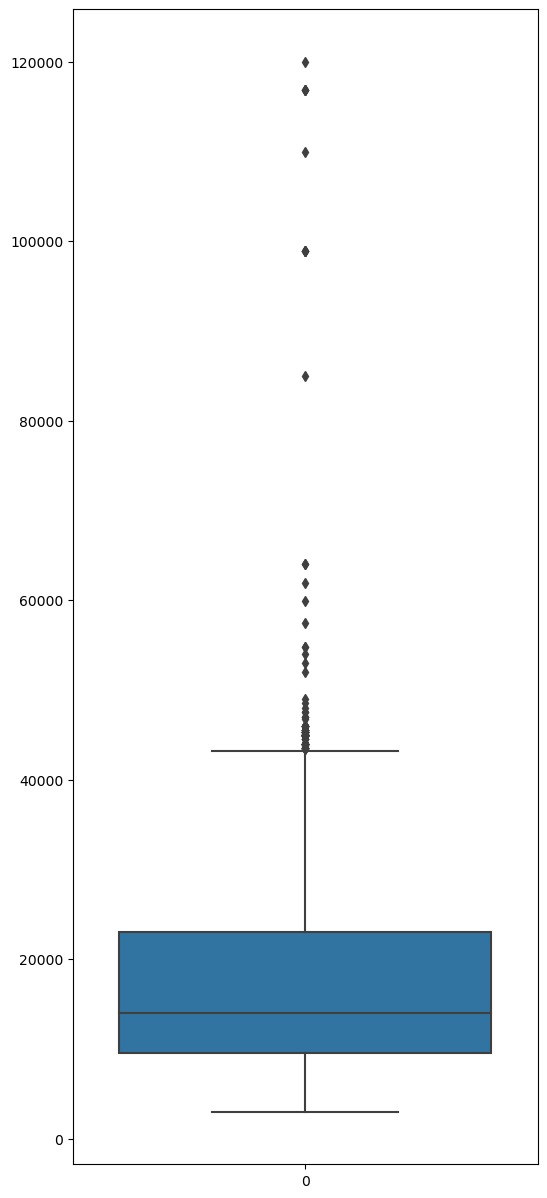

In [ ]:
show_series(cleaned_2, 'price')

In [ ]:
df = cleaned_2

## categorical to numeric 
- 브랜드별, 모델별 평균 가격을 랭크로 바꿔서 구하긴 했는데, 이상하면 그냥 제외하고 진행해도 돼!

### 제조사, 모델 수치화 (선택)
- 제조사 : 가격 평균을 순위화하여 구함
- 모델 : 해당 브랜드 내에서의 평균 가격 순위를 정규화 한 값 + 브랜드 순위

In [ ]:
df['count'] = 1
man_model_map_1 = pd.DataFrame(df.groupby(['manufacturer']).sum()[['count','price']])
man_model_map_1['price'] = round(man_model_map_1['price']/man_model_map_1['count'] ,2)
man_model_map_1.reset_index(inplace= True)
man_model_map_1 = man_model_map_1.sort_values('price', ascending=False)
man_model_map_1.reset_index(inplace= True, drop = True)
man_model_map_1['brand_id'] = man_model_map_1.index.tolist()
man_model_map_1['brand_id'] = man_model_map_1['brand_id'].apply(lambda x: len(man_model_map_1)-x)

man_model_map_1

,manufacturer,count,price,brand_id
0,ferrari,12,106421.75,41
1,aston-martin,2,47497.50,40
2,tesla,24,47001.00,39
3,ram,2269,31239.78,38
4,gmc,2719,27686.58,37
5,porsche,199,25942.97,36
6,alfa-romeo,32,24159.88,35
7,rover,238,22687.03,34
8,infiniti,883,22469.11,33
9,jaguar,255,22204.16,32


In [ ]:
maptable = man_model_map_1[['manufacturer','brand_id']]
df = df.merge(maptable, on='manufacturer', how='left')
df

,manufacturer,model,id,price,year,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,count,brand_id
0,ford,-150 xlt,7312098448,20997,2014.0,like new,8 cylinders,gas,145000.0,automatic,4wd,truck,silver,1,28
1,ford,/vmi conversion van,7316387772,18500,2013.0,excellent,8 cylinders,gas,47362.0,automatic,rwd,van,other,1,28
2,ford,150,7302231495,29988,2015.0,like new,6 cylinders,gas,95000.0,automatic,4wd,truck,other,1,28
3,ford,150 xlt,7313515244,21900,2014.0,excellent,8 cylinders,gas,94942.0,automatic,rwd,pickup,other,1,28
4,ford,250,7316861283,8200,1997.0,good,8 cylinders,gas,177000.0,other,4wd,truck,other,1,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61527,land rover,freelander,7310494602,6995,2003.0,good,6 cylinders,gas,112466.0,automatic,4wd,SUV,other,1,7
61528,land rover,lr2,7312512367,8500,2008.0,good,6 cylinders,gas,144563.0,automatic,4wd,SUV,silver,1,7
61529,land rover,lr2,7314020640,7995,2010.0,like new,6 cylinders,gas,139465.0,automatic,4wd,SUV,other,1,7
61530,aston-martin,martin db9,7316465896,42995,2006.0,like new,other,gas,39648.0,automatic,rwd,convertible,silver,1,40


In [ ]:
df['count'] = 1
man_model_map_2 = pd.DataFrame(df.groupby(['manufacturer','model']).sum()[['count','price']])
man_model_map_2['price'] = round(man_model_map_2['price']/man_model_map_2['count'] ,2)
man_model_map_2.reset_index(inplace= True)
man_model_map_2 = man_model_map_2.merge(maptable, on='manufacturer', how='left')
new_df = []
mans = man_model_map_2['manufacturer'].unique().tolist()
for man in mans:
    targ = man_model_map_2[man_model_map_2['manufacturer'] == man]
    targ.reset_index(inplace=True, drop = True)
    targ['model_id'] =rankdata(targ['price'], method='dense')/len(targ)*0.9
    targ['model_id'] = targ['model_id'].apply(lambda x: round(x,2))
    targ.reset_index(inplace= True, drop = True)
    new_df.append(targ)
new_df = pd.concat(new_df)
new_df.reset_index(inplace= True, drop = True)
new_df['model_id'] = new_df['model_id']+new_df['brand_id']

C:\Users\user\AppData\Local\Temp\ipykernel_24556\1426454938.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targ['model_id'] =rankdata(targ['price'], method='dense')/len(targ)*0.9
C:\Users\user\AppData\Local\Temp\ipykernel_24556\1426454938.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targ['model_id'] = targ['model_id'].apply(lambda x: round(x,2))
C:\Users\user\AppData\Local\Temp\ipykernel_24556\1426454938.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [ ]:
model_maptable = new_df[['manufacturer','model','model_id']]
df = df.merge(model_maptable, on=['manufacturer','model'], how='left')
df

,manufacturer,model,id,price,year,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,count,brand_id,model_id
0,ford,-150 xlt,7312098448,20997,2014.0,like new,8 cylinders,gas,145000.0,automatic,4wd,truck,silver,1,28,28.39
1,ford,/vmi conversion van,7316387772,18500,2013.0,excellent,8 cylinders,gas,47362.0,automatic,rwd,van,other,1,28,28.33
2,ford,150,7302231495,29988,2015.0,like new,6 cylinders,gas,95000.0,automatic,4wd,truck,other,1,28,28.53
3,ford,150 xlt,7313515244,21900,2014.0,excellent,8 cylinders,gas,94942.0,automatic,rwd,pickup,other,1,28,28.40
4,ford,250,7316861283,8200,1997.0,good,8 cylinders,gas,177000.0,other,4wd,truck,other,1,28,28.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61527,land rover,freelander,7310494602,6995,2003.0,good,6 cylinders,gas,112466.0,automatic,4wd,SUV,other,1,7,7.30
61528,land rover,lr2,7312512367,8500,2008.0,good,6 cylinders,gas,144563.0,automatic,4wd,SUV,silver,1,7,7.60
61529,land rover,lr2,7314020640,7995,2010.0,like new,6 cylinders,gas,139465.0,automatic,4wd,SUV,other,1,7,7.60
61530,aston-martin,martin db9,7316465896,42995,2006.0,like new,other,gas,39648.0,automatic,rwd,convertible,silver,1,40,40.45


### 원핫인코딩 및 정규화
- 뒤의 단계에서 컨디션, 드라이브, 타입 등의 원핫백터들을 PCA를 통해 한 차원의 백터값으로 축소

In [ ]:
df = pd.get_dummies(df, columns = ['condition','drive','type','cylinders','fuel','transmission','paint_color'])
df = df.replace(True,1).replace(False,0)
df

,manufacturer,model,id,price,year,odometer,count,brand_id,model_id,condition_excellent,...,cylinders_6 cylinders,cylinders_8 cylinders,cylinders_other,fuel_gas,fuel_other,transmission_automatic,transmission_other,paint_color_black,paint_color_other,paint_color_silver
0,ford,-150 xlt,7312098448,20997,2014.0,145000.0,1,28,28.39,0,...,0,1,0,1,0,1,0,0,0,1
1,ford,/vmi conversion van,7316387772,18500,2013.0,47362.0,1,28,28.33,1,...,0,1,0,1,0,1,0,0,1,0
2,ford,150,7302231495,29988,2015.0,95000.0,1,28,28.53,0,...,1,0,0,1,0,1,0,0,1,0
3,ford,150 xlt,7313515244,21900,2014.0,94942.0,1,28,28.40,1,...,0,1,0,1,0,1,0,0,1,0
4,ford,250,7316861283,8200,1997.0,177000.0,1,28,28.02,0,...,0,1,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61527,land rover,freelander,7310494602,6995,2003.0,112466.0,1,7,7.30,0,...,1,0,0,1,0,1,0,0,1,0
61528,land rover,lr2,7312512367,8500,2008.0,144563.0,1,7,7.60,0,...,1,0,0,1,0,1,0,0,0,1
61529,land rover,lr2,7314020640,7995,2010.0,139465.0,1,7,7.60,0,...,1,0,0,1,0,1,0,0,1,0
61530,aston-martin,martin db9,7316465896,42995,2006.0,39648.0,1,40,40.45,0,...,0,0,1,1,0,1,0,0,0,1


In [ ]:
colist = [ 'price', 'year', 'odometer', 
       'brand_id', 'model_id','condition_excellent', 'condition_fair',
       'condition_good', 'condition_like new', 'condition_new',
       'condition_salvage', 'drive_4wd', 'drive_fwd', 'drive_rwd', 'type_SUV',
       'type_bus', 'type_convertible', 'type_coupe', 'type_hatchback',
       'type_mini-van', 'type_offroad', 'type_other', 'type_pickup',
       'type_sedan', 'type_truck', 'type_van', 'type_wagon',
       'cylinders_4 cylinders', 'cylinders_6 cylinders',
       'cylinders_8 cylinders', 'cylinders_other', 'fuel_gas', 'fuel_other',
       'transmission_automatic', 'transmission_other', 'paint_color_black',
       'paint_color_other', 'paint_color_silver']
df_set = df[colist]
df_set

,price,year,odometer,brand_id,model_id,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,...,cylinders_6 cylinders,cylinders_8 cylinders,cylinders_other,fuel_gas,fuel_other,transmission_automatic,transmission_other,paint_color_black,paint_color_other,paint_color_silver
0,20997,2014.0,145000.0,28,28.39,0,0,0,1,0,...,0,1,0,1,0,1,0,0,0,1
1,18500,2013.0,47362.0,28,28.33,1,0,0,0,0,...,0,1,0,1,0,1,0,0,1,0
2,29988,2015.0,95000.0,28,28.53,0,0,0,1,0,...,1,0,0,1,0,1,0,0,1,0
3,21900,2014.0,94942.0,28,28.40,1,0,0,0,0,...,0,1,0,1,0,1,0,0,1,0
4,8200,1997.0,177000.0,28,28.02,0,0,1,0,0,...,0,1,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61527,6995,2003.0,112466.0,7,7.30,0,0,1,0,0,...,1,0,0,1,0,1,0,0,1,0
61528,8500,2008.0,144563.0,7,7.60,0,0,1,0,0,...,1,0,0,1,0,1,0,0,0,1
61529,7995,2010.0,139465.0,7,7.60,0,0,0,1,0,...,1,0,0,1,0,1,0,0,1,0
61530,42995,2006.0,39648.0,40,40.45,0,0,0,1,0,...,0,0,1,1,0,1,0,0,0,1


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # StandardScaler 클래스 생성
scaler.fit(df_set) # 표준화를 수행 함수 생성
transformed_X = scaler.transform(df_set) # 표준화 수행


In [ ]:
df_set = pd.DataFrame(transformed_X)
df_set.columns = colist
df_set

,price,year,odometer,brand_id,model_id,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,...,cylinders_6 cylinders,cylinders_8 cylinders,cylinders_other,fuel_gas,fuel_other,transmission_automatic,transmission_other,paint_color_black,paint_color_other,paint_color_silver
0,0.426474,0.366351,1.126476,0.506026,0.507541,-1.017179,-0.072869,-0.762358,2.773037,-0.052945,...,-0.761000,1.560771,-0.138372,0.290316,-0.290316,0.446053,-0.446053,-0.498872,-1.385621,2.446128
1,0.159750,0.247943,-1.046962,0.506026,0.500695,0.983111,-0.072869,-0.762358,-0.360615,-0.052945,...,-0.761000,1.560771,-0.138372,0.290316,-0.290316,0.446053,-0.446053,-0.498872,0.721698,-0.408809
2,1.386873,0.484758,0.013468,0.506026,0.523516,-1.017179,-0.072869,-0.762358,2.773037,-0.052945,...,1.314061,-0.640709,-0.138372,0.290316,-0.290316,0.446053,-0.446053,-0.498872,0.721698,-0.408809
3,0.522931,0.366351,0.012177,0.506026,0.508682,0.983111,-0.072869,-0.762358,-0.360615,-0.052945,...,-0.761000,1.560771,-0.138372,0.290316,-0.290316,0.446053,-0.446053,-0.498872,0.721698,-0.408809
4,-0.940473,-1.646577,1.838801,0.506026,0.465322,-1.017179,-0.072869,1.311720,-0.360615,-0.052945,...,-0.761000,1.560771,-0.138372,0.290316,-0.290316,-2.241885,2.241885,-0.498872,0.721698,-0.408809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61527,-1.069188,-0.936132,0.402264,-1.894809,-1.898967,-1.017179,-0.072869,1.311720,-0.360615,-0.052945,...,1.314061,-0.640709,-0.138372,0.290316,-0.290316,0.446053,-0.446053,-0.498872,0.721698,-0.408809
61528,-0.908427,-0.344094,1.116748,-1.894809,-1.864735,-1.017179,-0.072869,1.311720,-0.360615,-0.052945,...,1.314061,-0.640709,-0.138372,0.290316,-0.290316,0.446053,-0.446053,-0.498872,-1.385621,2.446128
61529,-0.962370,-0.107279,1.003266,-1.894809,-1.864735,-1.017179,-0.072869,-0.762358,2.773037,-0.052945,...,1.314061,-0.640709,-0.138372,0.290316,-0.290316,0.446053,-0.446053,-0.498872,0.721698,-0.408809
61530,2.776251,-0.580909,-1.218676,1.877931,1.883667,-1.017179,-0.072869,-0.762358,2.773037,-0.052945,...,-0.761000,-0.640709,7.226920,0.290316,-0.290316,0.446053,-0.446053,-0.498872,-1.385621,2.446128


# 진행중인 부분!

## Feature Extraction
- 본격적인 클러스터 분석 이전, 가격에 영향을 미치는 주요 피쳐 선정

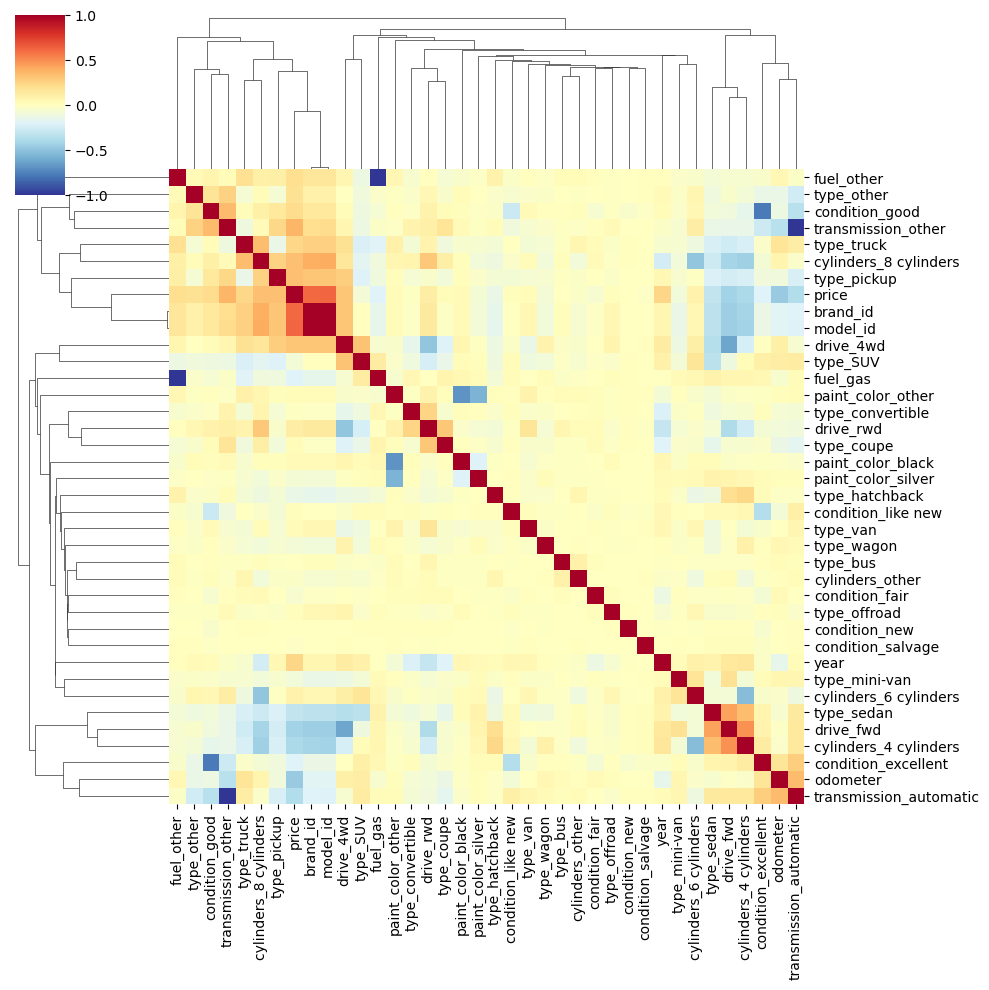

In [ ]:
heat = df_set.corr()

sns.clustermap(heat, 
               annot = False,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )

In [ ]:
heat['price'].sort_values(ascending=False)

price                     1.000000
model_id                  0.621497
brand_id                  0.611746
transmission_other        0.371117
cylinders_8 cylinders     0.331142
type_pickup               0.330492
drive_4wd                 0.305360
year                      0.240033
type_truck                0.232607
condition_good            0.205644
fuel_other                0.201708
type_other                0.181029
drive_rwd                 0.110957
cylinders_6 cylinders     0.078758
paint_color_black         0.032234
type_van                  0.027583
type_coupe                0.026892
paint_color_other         0.024953
condition_like new        0.012273
type_offroad              0.011808
type_bus                 -0.002037
condition_new            -0.005600
type_convertible         -0.011841
condition_salvage        -0.016771
cylinders_other          -0.029344
condition_fair           -0.055375
paint_color_silver       -0.070567
type_wagon               -0.080244
type_SUV            

In [ ]:
heat[(heat['price'] > 0.3) | (heat['price'] < -0.3) ]

,price,year,odometer,brand_id,model_id,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,...,cylinders_6 cylinders,cylinders_8 cylinders,cylinders_other,fuel_gas,fuel_other,transmission_automatic,transmission_other,paint_color_black,paint_color_other,paint_color_silver
price,1.000000,0.240033,-0.465045,0.611746,0.621497,-0.196615,-0.055375,0.205644,0.012273,-0.005600,...,0.078758,0.331142,-0.029344,-0.201708,0.201708,-0.371117,0.371117,0.032234,0.024953,-0.070567
odometer,-0.465045,-0.155343,1.000000,-0.181860,-0.186653,0.161985,0.037151,-0.118587,-0.082590,-0.000318,...,-0.033848,0.067263,0.006832,-0.051665,0.051665,0.347444,-0.347444,-0.020360,0.009306,0.010612
brand_id,0.611746,0.058455,-0.181860,1.000000,0.999820,-0.128854,-0.021493,0.141570,-0.005736,-0.005338,...,0.050654,0.397469,-0.060066,-0.151571,0.151571,-0.199760,0.199760,0.035554,0.028602,-0.079295
model_id,0.621497,0.061456,-0.186653,0.999820,1.000000,-0.132262,-0.021831,0.145747,-0.006592,-0.005508,...,0.053517,0.398868,-0.060276,-0.153261,0.153261,-0.206207,0.206207,0.036333,0.028362,-0.079860
drive_4wd,0.305360,0.119600,0.095042,0.306373,0.309806,-0.007318,-0.007268,0.024815,-0.024161,-0.001403,...,0.106124,0.148839,-0.043025,-0.055499,0.055499,-0.056584,0.056584,0.055041,-0.039111,-0.009784
drive_fwd,-0.422941,0.142386,-0.017115,-0.446799,-0.451379,0.072443,-0.013008,-0.097760,0.036361,0.000518,...,-0.083092,-0.417502,0.020470,0.060447,-0.060447,0.145754,-0.145754,-0.026654,-0.029369,0.070185
type_pickup,0.330492,0.042150,-0.098218,0.308087,0.310852,-0.094702,-0.001296,0.146228,-0.070767,-0.006749,...,-0.009818,0.252406,-0.024868,-0.104046,0.104046,-0.227908,0.227908,0.015570,0.011156,-0.032871
type_sedan,-0.316401,0.075546,-0.049597,-0.331299,-0.334645,0.063348,-0.015644,-0.089318,0.038008,0.002690,...,-0.076694,-0.269258,0.009329,0.085387,-0.085387,0.133072,-0.133072,0.029258,-0.076966,0.070904
cylinders_4 cylinders,-0.394169,0.153412,-0.032427,-0.420705,-0.424953,0.119494,-0.015874,-0.150906,0.042536,0.005506,...,-0.526174,-0.443002,-0.095674,0.057873,-0.057873,0.146299,-0.146299,-0.022616,-0.016920,0.048715
cylinders_8 cylinders,0.331142,-0.246437,0.067263,0.397469,0.398868,-0.072747,0.036237,0.095477,-0.038660,0.004027,...,-0.487579,1.000000,-0.088656,-0.101418,0.101418,-0.036471,0.036471,0.009254,0.057677,-0.088693


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components= 1) # 주성분을 몇개로 할지 결정


pcad = df[['condition_excellent', 'condition_fair',
       'condition_good', 'condition_like new', 'condition_new',
       'condition_salvage', 'drive_4wd', 'drive_fwd', 'drive_rwd', 'type_SUV',
       'type_bus', 'type_convertible', 'type_coupe', 'type_hatchback',
       'type_mini-van', 'type_offroad', 'type_other', 'type_pickup',
       'type_sedan', 'type_truck', 'type_van', 'type_wagon',
       'cylinders_4 cylinders', 'cylinders_6 cylinders',
       'cylinders_8 cylinders', 'cylinders_other', 'fuel_gas', 'fuel_other',
       'transmission_automatic', 'transmission_other', 'paint_color_black',
       'paint_color_other', 'paint_color_silver']]

featureset =pcad

printcipalComponents = pca.fit_transform(featureset)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['pc1'])
principalDf

,pc1
0,0.632069
1,0.135642
2,0.548555
3,0.285557
4,1.444374
...,...
61527,0.767095
61528,0.681383
61529,0.442787
61530,0.016956


In [ ]:
pca.explained_variance_ratio_

array([0.17641382])

In [ ]:
ndf = df_set[['price', 'year', 'odometer','brand_id', 'model_id']]
ndf['total_category'] = principalDf['pc1']
ndf

C:\Users\user\AppData\Local\Temp\ipykernel_24556\2682734562.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['total_category'] = principalDf['pc1']


,price,year,odometer,brand_id,model_id,total_category
0,0.426474,0.366351,1.126476,0.506026,0.507541,0.632069
1,0.159750,0.247943,-1.046962,0.506026,0.500695,0.135642
2,1.386873,0.484758,0.013468,0.506026,0.523516,0.548555
3,0.522931,0.366351,0.012177,0.506026,0.508682,0.285557
4,-0.940473,-1.646577,1.838801,0.506026,0.465322,1.444374
...,...,...,...,...,...,...
61527,-1.069188,-0.936132,0.402264,-1.894809,-1.898967,0.767095
61528,-0.908427,-0.344094,1.116748,-1.894809,-1.864735,0.681383
61529,-0.962370,-0.107279,1.003266,-1.894809,-1.864735,0.442787
61530,2.776251,-0.580909,-1.218676,1.877931,1.883667,0.016956


In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=500)
cluster = kmeans.fit(ndf)
ndf['kmeans_cluster'] = cluster.labels_
ndf

c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\AppData\Local\Temp\ipykernel_24556\2838207914.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['kmeans_cluster'] = cluster.labels_


,price,year,odometer,brand_id,model_id,total_category,kmeans_cluster
0,0.426474,0.366351,1.126476,0.506026,0.507541,0.632069,2
1,0.159750,0.247943,-1.046962,0.506026,0.500695,0.135642,5
2,1.386873,0.484758,0.013468,0.506026,0.523516,0.548555,5
3,0.522931,0.366351,0.012177,0.506026,0.508682,0.285557,5
4,-0.940473,-1.646577,1.838801,0.506026,0.465322,1.444374,9
...,...,...,...,...,...,...,...
61527,-1.069188,-0.936132,0.402264,-1.894809,-1.898967,0.767095,0
61528,-0.908427,-0.344094,1.116748,-1.894809,-1.864735,0.681383,0
61529,-0.962370,-0.107279,1.003266,-1.894809,-1.864735,0.442787,0
61530,2.776251,-0.580909,-1.218676,1.877931,1.883667,0.016956,3


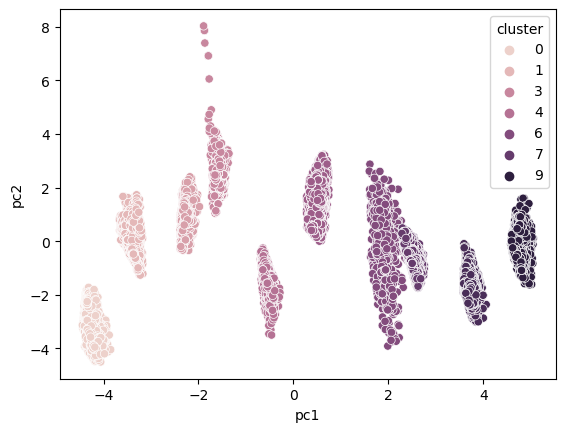

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(ndf)
principalDf = pd.DataFrame(data=principalComponents, columns = ['pc1', 'pc2'])
principalDf['cluster'] = ndf['kmeans_cluster']
axs = plt.subplots()
axs = sns.scatterplot(x='pc1', y='pc2', hue='cluster', data=principalDf)

In [ ]:
ndf

,price,year,odometer,brand_id,model_id,total_category,kmeans_cluster
0,0.426474,0.366351,1.126476,0.506026,0.507541,0.632069,1
1,0.159750,0.247943,-1.046962,0.506026,0.500695,0.135642,3
2,1.386873,0.484758,0.013468,0.506026,0.523516,0.548555,2
3,0.522931,0.366351,0.012177,0.506026,0.508682,0.285557,3
4,-0.940473,-1.646577,1.838801,0.506026,0.465322,1.444374,0
...,...,...,...,...,...,...,...
61527,-1.069188,-0.936132,0.402264,-1.894809,-1.898967,0.767095,3
61528,-0.908427,-0.344094,1.116748,-1.894809,-1.864735,0.681383,3
61529,-0.962370,-0.107279,1.003266,-1.894809,-1.864735,0.442787,3
61530,2.776251,-0.580909,-1.218676,1.877931,1.883667,0.016956,2


In [ ]:
# create model and predictio
from sklearn.cluster import DBSCAN
model = DBSCAN(min_samples=13)
#ndf.drop(['cluster'], axis=1, inplace=True)
dbscandf = ndf[['price', 'year', 'odometer','brand_id', 'model_id','total_category']]
predict = pd.DataFrame(model.fit_predict(dbscandf))
predict.columns=['predict']


In [ ]:
dbscandf['cluster'] = predict['predict']
dbscandf

,price,year,odometer,brand_id,model_id,total_category,cluster
0,0.426474,0.366351,1.126476,0.506026,0.507541,0.632069,0
1,0.159750,0.247943,-1.046962,0.506026,0.500695,0.135642,0
2,1.386873,0.484758,0.013468,0.506026,0.523516,0.548555,0
3,0.522931,0.366351,0.012177,0.506026,0.508682,0.285557,0
4,-0.940473,-1.646577,1.838801,0.506026,0.465322,1.444374,0
...,...,...,...,...,...,...,...
61527,-1.069188,-0.936132,0.402264,-1.894809,-1.898967,0.767095,0
61528,-0.908427,-0.344094,1.116748,-1.894809,-1.864735,0.681383,0
61529,-0.962370,-0.107279,1.003266,-1.894809,-1.864735,0.442787,0
61530,2.776251,-0.580909,-1.218676,1.877931,1.883667,0.016956,-1


In [ ]:
dbscandf.groupby(['cluster']).count()

,price,year,odometer,brand_id,model_id,total_category
cluster,,,,,,
-1,2435,2435,2435,2435,2435,2435
0,58780,58780,58780,58780,58780,58780
1,17,17,17,17,17,17
2,20,20,20,20,20,20
3,146,146,146,146,146,146
4,20,20,20,20,20,20
5,22,22,22,22,22,22
6,20,20,20,20,20,20
7,9,9,9,9,9,9


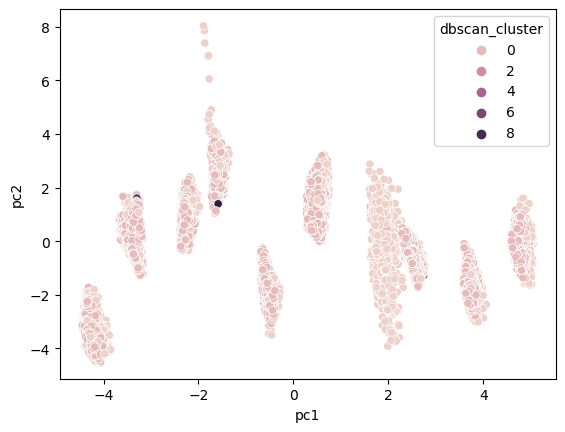

In [ ]:
principalDf['dbscan_cluster'] = dbscandf['cluster']
axs = plt.subplots()
axs = sns.scatterplot(x='pc1', y='pc2', hue='dbscan_cluster', data=principalDf)

In [ ]:
year_odo = df_set[['year','odometer']]
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=30, random_state=0)
cluster = kmeans.fit(year_odo)
df_set['year_odo_cluster'] = cluster.labels_

kmeans = KMeans(n_clusters=30, random_state=0)
brand_model = df_set[['price','model_id']]
cluster = kmeans.fit(brand_model)
df_set['brand_model_cluster'] = cluster.labels_

df_set

c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,price,year,odometer,brand_id,model_id,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,...,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow,year_odo_cluster,brand_model_cluster
0,0.426474,0.366351,1.126476,0.506026,0.507541,-1.017179,-0.072869,-0.762358,2.773037,-0.052945,...,-0.152306,-0.356806,-0.072981,-0.047583,-0.345240,2.446128,-0.569493,-0.09133,2,9
1,0.159750,0.247943,-1.046962,0.506026,0.500695,0.983111,-0.072869,-0.762358,-0.360615,-0.052945,...,-0.152306,-0.356806,-0.072981,-0.047583,2.896532,-0.408809,-0.569493,-0.09133,26,9
2,1.386873,0.484758,0.013468,0.506026,0.523516,-1.017179,-0.072869,-0.762358,2.773037,-0.052945,...,-0.152306,-0.356806,-0.072981,-0.047583,-0.345240,-0.408809,1.755947,-0.09133,9,3
3,0.522931,0.366351,0.012177,0.506026,0.508682,0.983111,-0.072869,-0.762358,-0.360615,-0.052945,...,-0.152306,2.802641,-0.072981,-0.047583,-0.345240,-0.408809,-0.569493,-0.09133,9,9
4,-0.940473,-1.646577,1.838801,0.506026,0.465322,-1.017179,-0.072869,1.311720,-0.360615,-0.052945,...,-0.152306,-0.356806,-0.072981,-0.047583,-0.345240,-0.408809,1.755947,-0.09133,10,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61527,-1.069188,-0.936132,0.402264,-1.894809,-1.898967,-1.017179,-0.072869,1.311720,-0.360615,-0.052945,...,-0.152306,2.802641,-0.072981,-0.047583,-0.345240,-0.408809,-0.569493,-0.09133,11,4
61528,-0.908427,-0.344094,1.116748,-1.894809,-1.864735,-1.017179,-0.072869,1.311720,-0.360615,-0.052945,...,-0.152306,-0.356806,-0.072981,-0.047583,-0.345240,2.446128,-0.569493,-0.09133,19,4
61529,-0.962370,-0.107279,1.003266,-1.894809,-1.864735,-1.017179,-0.072869,-0.762358,2.773037,-0.052945,...,-0.152306,-0.356806,-0.072981,-0.047583,-0.345240,-0.408809,1.755947,-0.09133,21,4
61530,2.776251,-0.580909,-1.218676,1.877931,1.883667,-1.017179,-0.072869,-0.762358,2.773037,-0.052945,...,-0.152306,-0.356806,-0.072981,-0.047583,-0.345240,2.446128,-0.569493,-0.09133,6,22
